### 1. Импортировать библиотеки в Python.

In [538]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import scipy
import torch

torch.cuda.synchronize()
torch.cuda.empty_cache()

cuda = torch.device('cuda')

### 2. Загрузка и подготовка данных.

In [539]:
name = random.choice(os.listdir("dataset"))

name = 'testLab1Var7.csv'

print(f"Dataset: {name}")

dataset = np.genfromtxt(f"dataset/{name}", delimiter=',')

dataset = [dataset[:, i] for i in range(dataset.shape[1])]
title = ["time", "current", "voltage"]

dataset_dict = dict(zip(title, dataset))

Dataset: testLab1Var7.csv


### 3. Нарисовать графики тока и напряжения.

Для удобства отображения отображу не весь график, а некоторый его случайный диапазон заданного размера, установив лимиты на данные.

In [540]:
"""
Размер интервала
"""
time_period = 0.1

In [541]:
time_interval = random.random() * (dataset_dict["time"][-1] - time_period)
time_interval = (time_interval, time_interval + time_period)

print(f"Временной интервал {time_interval}")

Временной интервал (46.33177893047615, 46.43177893047615)


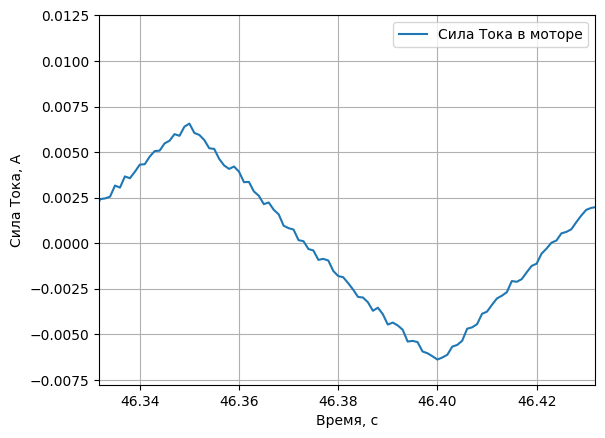

In [542]:
plt.plot(dataset_dict["time"], dataset_dict["current"])
plt.xlim(time_interval)
plt.grid()
plt.xlabel('Время, с')
plt.ylabel('Сила Тока, А')
plt.legend(["Сила Тока в моторе"])

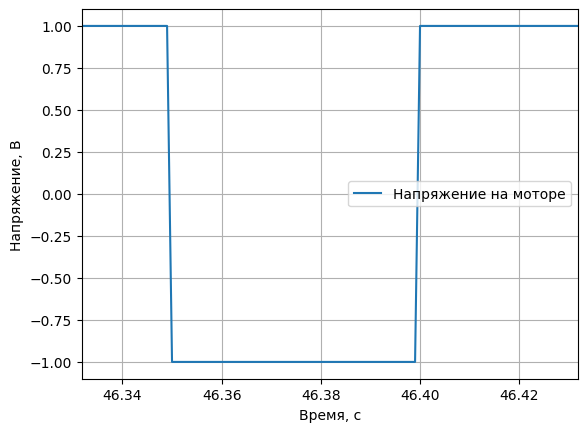

In [543]:
plt.plot(dataset_dict["time"], dataset_dict["voltage"])
plt.xlim(time_interval)
plt.grid()
plt.xlabel('Время, с')
plt.ylabel('Напряжение, В')
plt.legend(["Напряжение на моторе"])

### 4. Рассчитать значения параметров L и R.

Упрощённая модель двигателя постоянного тока. Модель двигателя постоянного тока описывается следующей системой дифференциальных уравнений:

di/dt = 1 / L * u - R / L * i - Ce

dΩ/dt = Ce / J * i - 1 / J * Md

Y = K*X

I(k) = (Ts / L) * U(k-1) - ((R*Ts - L) / L) * I(k-1)

I(k) = K1 * U(k-1) + K2 * I(k-1)



In [544]:
X = np.transpose(np.concatenate([np.array([dataset_dict["voltage"], ]), np.array([dataset_dict["current"], ])], axis=0))
Y = np.transpose(np.array([dataset_dict["current"], ]))

# X : n*k
# K : k*1
# X * K = Y
# [U(k-1);I(k-1)] * K = [I(k)]

X = X[:-1, :]  # U(k-1);I(k-1)
Y = Y[1:, :]  # I(k)

print(X.shape)
print(Y.shape)

X_tensor = torch.tensor(X, device=cuda, dtype=torch.float64)
Y_tensor = torch.tensor(Y, device=cuda, dtype=torch.float64)

(100000, 2)
(100000, 1)


Функция нахождения [псевдообратной матрицы Moore–Penrose](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) через Сингулярное Разложение.

Данная матрица позволяет аппроксимировать $Y = X \times K + e$ [Методом Наименьших Квадратов](https://www.gaussianwaves.com/2014/06/linear-models-least-squares-estimator-lse/amp/):

In [545]:
def get_pseudoinverse(matrix):
    matrix_svd = torch.svd(matrix)

    matrix_psi = matrix_svd.V
    matrix_psi = torch.mm(matrix_psi, torch.diag(1 / matrix_svd.S))
    matrix_psi = torch.mm(matrix_psi, matrix_svd.U.T)

    return matrix_psi

In [546]:
X_psi = get_pseudoinverse(X_tensor)

print(X_psi.shape)
print(X_tensor.shape)

torch.Size([2, 100000])
torch.Size([100000, 2])


Результатом перемножения псевдообратной матрицы от X и самой матрицы X должна быть матрица, близкая к единичной:

In [547]:
print(torch.mm(X_psi, X_tensor))

tensor([[ 1.0000e+00, -6.7233e-20],
        [-7.0222e-15,  1.0000e+00]], device='cuda:0', dtype=torch.float64)


$X \times K = Y \to K = X^{+} \times Y$, где $X^{+}$ - матрица, псевдообратная к X

In [548]:
K_approx = torch.mm(X_psi, Y_tensor)
print(K_approx)

tensor([[2.6420e-04],
        [9.9339e-01]], device='cuda:0', dtype=torch.float64)


Для нахождения ошибки между реальным значением $Y$ и его предсказанием моделью $X \times K$, можно просто посчитать их разность $e = Y - X \times K$

Тогда Сумма квадратов ошибки будет $S(K) = \sum_{}^{} e_{i}^{2} = e^{T} \times e = (Y - X \times K)^{T} \times (Y - X \times K)$

А среднеквадратичное отклонение $ \sigma = \sqrt{\dfrac{S(K)}{n}}$

In [549]:
e2_Y = torch.mm(Y_tensor.T - torch.mm(X_tensor, K_approx).T, Y_tensor - torch.mm(X_tensor, K_approx))
sigma2_Y = torch.divide(e2_Y, Y_tensor.shape[0])

sigma_Y = torch.sqrt(sigma2_Y)
sigma_Y = sigma_Y.cpu().numpy()[0][0]

print(sigma_Y)

0.00021120826770868625


(100000,)
(100000,)


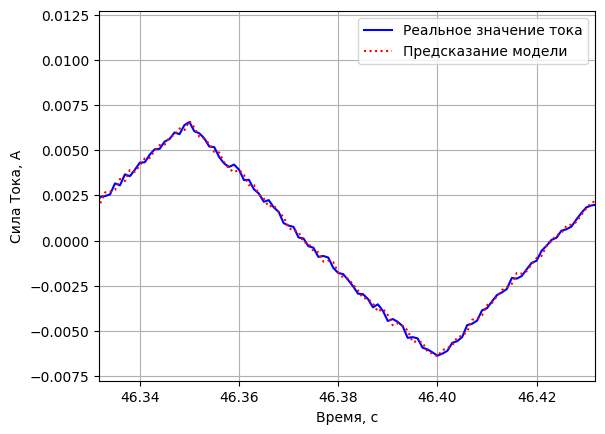

In [550]:
Y_predict = torch.mm(X_tensor, K_approx)
Y_predict = Y_predict.cpu().numpy()

print(Y_predict.T[0].shape)
print(dataset_dict["current"][1:].shape)

plt.plot(dataset_dict["time"][1:], dataset_dict["current"][1:], 'b')
plt.plot(dataset_dict["time"][1:], Y_predict.T[0], 'r:')
plt.xlim(time_interval)
plt.grid()
plt.xlabel('Время, с')
plt.ylabel('Сила Тока, А')
plt.legend(["Реальное значение тока", "Предсказание модели"])

(100000,)
(100000,)


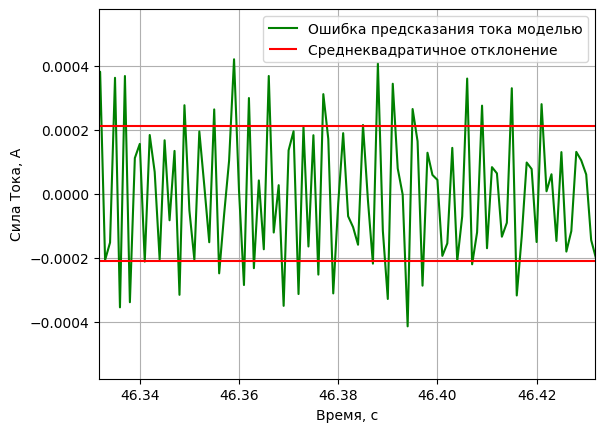

In [551]:
print(Y_predict.T[0].shape)
print(dataset_dict["current"][1:].shape)

plt.plot(dataset_dict["time"][1:], dataset_dict["current"][1:] - Y_predict.T[0], 'g')
plt.hlines([-sigma_Y, sigma_Y], dataset_dict["time"][0], dataset_dict["time"][-1], 'r')
plt.xlim(time_interval)
plt.grid()
plt.xlabel('Время, с')
plt.ylabel('Сила Тока, А')
plt.legend(["Ошибка предсказания тока моделью", "Среднеквадратичное отклонение"])

In [552]:
K = K_approx.cpu()
print(K)

Td = 0.001

L = Td / K[0]
R = (L - K[1] * L) / Td

print(R)
print(L)

tensor([[2.6420e-04],
        [9.9339e-01]], dtype=torch.float64)
tensor([25.0275], dtype=torch.float64)
tensor([3.7850], dtype=torch.float64)


In [553]:
Td = 0.001

R_est = []
L_est = []

if K[1] > 0:
    R = 1 / K[0] * (1 - K[1])
    T = -Td / np.log(K[1])
    R_est.append(R)
    L_est.append(T * R)

R_est = np.array(R_est)
L_est = np.array(L_est)

C:\Users\zhidk\AppData\Local\Temp\ipykernel_10276\2326068066.py:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  R_est = np.array(R_est)
C:\Users\zhidk\AppData\Local\Temp\ipykernel_10276\2326068066.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to

In [554]:
print('Mean value of R: ', np.mean(R_est), ' Ohm')
print('Standart deviation of R: ', np.std(R_est))
print('Mean value of L = ', np.mean(L_est), ' Hn')
print('Standart deviation of R: ', np.std(L_est))

Mean value of R:  25.027544616804754  Ohm
Standart deviation of R:  0.0
Mean value of L =  3.7724892844348483  Hn
Standart deviation of R:  0.0


In [555]:
# K1 = (Ts / L)
# L = Ts / K1
# K2 = - ((R*Ts - L) / L)
# K2 * L = L - R*Ts
# R*Ts = L - K2 * L
# R = (L - K2 * L) / Ts


L = Td / K[0]
R = (L - K[1] * L) / Td



print('R = ', R, ' Ohm')
print('L = ', L, ' Hn')

R =  tensor([25.0275], dtype=torch.float64)  Ohm
L =  tensor([3.7850], dtype=torch.float64)  Hn
